In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import target
import importlib
from target import calculate_target
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
importlib.reload(target)

<module 'target' from '/home/alessio/MarGui-Project/target.py'>

In [17]:
ticker = "AAPL"
predict_colum = "Close"
index_colum = "Date"
ARIMA_ORDER = (1, 1, 0) 

In [18]:
df = pd.read_csv(
    f"csv/{ticker}_indicators.csv",
    index_col=0,
    parse_dates=[0],
    date_format="ISO8601"
)

df = df.sort_index()

# Infer frequency
inferred = pd.infer_freq(df.index)  # type: ignore
if inferred:
    df = df.asfreq(inferred)
else:
    df = df.asfreq('B')

# Handle missing values - forward fill then backward fill
df = df.ffill().bfill()

df = df.astype(float)

# Define forecast horizon
forecast_horizon = 5

# Create target variables: Close price 1, 2, 3, 4, 5 days ahead
for i in range(1, forecast_horizon + 1):
    df[f'Close_t+{i}'] = df[predict_colum].shift(-i)

# Remove rows where we don't have future values
df = df.dropna()

# Define exogenous variables (exclude Close and future targets)
exog_cols = [col for col in df.columns 
             if not col.startswith('Close')]

print(f"Total features available: {len(exog_cols)}")

# Split data
train_size = int(len(df) * 0.85)
train_data = df[:train_size]
test_data = df[train_size:]

X_train_raw = train_data[exog_cols]
X_test_raw = test_data[exog_cols]

# Feature selection: Select top K most predictive features
k_best = 7  # Reduce from 50+ to 15 best features

# Use t+1 target for feature selection (most relevant short-term)
selector = SelectKBest(f_regression, k=k_best)
selector.fit(X_train_raw, train_data['Close_t+1'])

# Get selected feature names
selected_mask = selector.get_support()
selected_features = X_train_raw.columns[selected_mask].tolist()

print(f"\nSelected {len(selected_features)} best features:")
for feat in selected_features:
    print(f"  - {feat}")

# Filter to selected features
X_train_raw = X_train_raw[selected_features]
X_test_raw = X_test_raw[selected_features]

# Scale the features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_raw),
    index=X_train_raw.index,
    columns=X_train_raw.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_raw),
    index=X_test_raw.index,
    columns=X_test_raw.columns
)

Total features available: 53

Selected 7 best features:
  - High
  - Low
  - Open
  - SMA
  - EMA20
  - Boll_Up
  - Boll_Down


In [19]:
# Train models for each horizon
models = {}
predictions = {i: [] for i in range(1, forecast_horizon + 1)}

for day_ahead in range(1, forecast_horizon + 1):
    print(f"\nTraining model for t+{day_ahead}...")
    
    y_train = train_data[f'Close_t+{day_ahead}']
    
    # Try simpler ARIMA order if convergence fails
    model = ARIMA(y_train, exog=X_train_scaled, order=ARIMA_ORDER)
    fitted = model.fit()
    models[day_ahead] = fitted
    print(f"   Converged with order {ARIMA_ORDER}")
    
    # Predict on test set
    forecast = fitted.forecast(steps=len(test_data), exog=X_test_scaled)
    predictions[day_ahead] = forecast


Training model for t+1...


/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Converged with order (1, 1, 0)

Training model for t+2...


/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Converged with order (1, 1, 0)

Training model for t+3...


/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Converged with order (1, 1, 0)

Training model for t+4...


/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Converged with order (1, 1, 0)

Training model for t+5...


/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Converged with order (1, 1, 0)


In [20]:
# Prediction function
def predict_next_5_days(models = models, scaler = scaler, current_features = X_train_raw.iloc[-1]):
    """
    Given today's features, predict next 5 days
    
    Args:
        models: dict of fitted ARIMA models
        scaler: fitted StandardScaler
        current_features: Series with feature names matching training
    
    Returns:
        array of 5 predicted closing prices
    """
    # Scale features - ensure it's a DataFrame with column names
    features_df = pd.DataFrame([current_features])
    features_scaled = scaler.transform(features_df)
    
    predictions = []
    for day_ahead in range(1, 6):
        pred = models[day_ahead].forecast(steps=1, exog=features_scaled)
        predictions.append(pred.iloc[0])  # Use .iloc[0] instead of [0]
    return np.array(predictions)



--- CONFUSION MATRIX (ARIMA Target vs Predicted) ---
              precision    recall  f1-score   support

           1       0.43      0.52      0.47       118
           0       0.63      0.54      0.58       178

    accuracy                           0.53       296
   macro avg       0.53      0.53      0.53       296
weighted avg       0.55      0.53      0.54       296



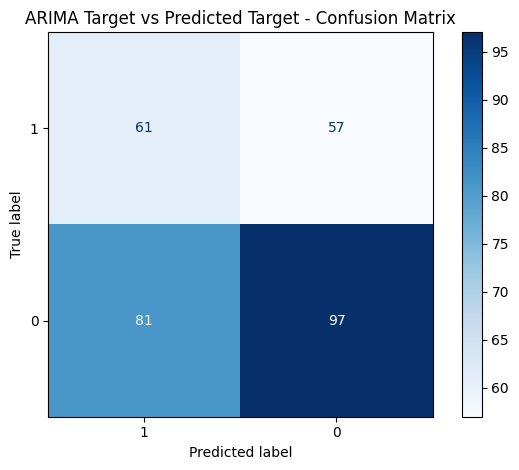

In [21]:
df = test_data.copy()

# Standardize column names to string and strip whitespace
df.columns = df.columns.astype(str).str.strip()

# Ensure all selected_features and 'Close' are present
required_cols = set([str(col).strip() for col in selected_features] + ['Close'])
missing_cols = required_cols - set(df.columns)
if missing_cols:
    raise ValueError(f"Missing columns in test_data: {missing_cols}")

df['Target'] = calculate_target(df, profit_take_pct=2, stop_loss_pct=1.0)
#print(df.index)
df = df.dropna(subset=["Target"])
df['Target'] = df['Target'].astype(int)

def arima(row):
    # Defensive: ensure all selected_features are present in the row
    try:
        features = row[selected_features]
    except KeyError as e:
        print(f"Missing feature in row: {e}")
        return np.nan

    # Get the 5-day predicted closing prices
    predicted_closes = predict_next_5_days(models=models, scaler=scaler, current_features=features)
    
    # Create a DataFrame that mimics the structure expected by calculate_target
    data = np.concatenate([[row['Close']], predicted_closes])
    predicted_df = pd.DataFrame({
        'Close': data,
        'High': data,
        'Low': data
    })
    
    # Calculate target on the predicted data
    target_result = calculate_target(predicted_df, profit_take_pct=2, stop_loss_pct=1.0)
    
    # Return the first valid target (since we only care about the signal from day 1)
    vale = target_result.iloc[0] if not target_result.empty else np.nan
    return vale

# Apply the arima function to each row
df['Predicted_Target'] = df.apply(arima, axis=1)
df['Predicted_Target'] = df['Predicted_Target'].astype(int)  # Convert to integer

print("\n--- CONFUSION MATRIX (ARIMA Target vs Predicted) ---")
print(classification_report(df["Target"], df["Predicted_Target"], labels=[1, 0]))

cm = confusion_matrix(df["Target"], df["Predicted_Target"], labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap=plt.cm.Blues)
plt.title('ARIMA Target vs Predicted Target - Confusion Matrix')
plt.tight_layout()
plt.show()

In [22]:
starting_cash = 1000

state = {
    "cash": starting_cash,
    "shares": 0.0,
    "streak": 0,
    "buy_price": 0,
    "max_price": 0
}

def arima_strategy(row):
    price = float(row["Close"])

    if row["Predicted_Target"] == 1:
        state["streak"] = 0
        if state["shares"] == 0:
            # Buy completo
            state["max_price"] = price
            state["buy_price"] = price
            state["shares"] += state["cash"] / price
            state["cash"] = 0.0
            state["streak"] = 0
        
    if row["Predicted_Target"] == 0:
        state["streak"] += 1
        if state["shares"] != 0 and (state["streak"] > 5):
            # Vendita totale
            state["cash"] += state["shares"] * price
            state["shares"] = 0.0
            state["streak"] = 0

    return state["cash"] + (state["shares"] * price)

# Uso la strategia sul data set
df["model_value"] = df.apply(arima_strategy, axis=1)

# Final payout
final_price = float(df.iloc[-1]["Close"])
payout_arima = state["cash"] + (state["shares"] * final_price)

print(f"Testing sul periodo che va dal {df.index[0].date()} a {df.index[-1].date()}")

print(f"Modello: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_arima} | Guadagno {((payout_arima - starting_cash)/starting_cash) * 100:.3f} %")

Testing sul periodo che va dal 2024-09-27 a 2025-11-14
Modello: Soldi di partenza: 1000 | Soldi alla fine 1251.4943159122502 | Guadagno 25.149 %
